In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import pandas as pd
import os
from matplotlib import pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-14m"
hookpoints = ["gpt_neox.layers.3.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

In [8]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': int(math.sqrt(input_size*expansion_factor)),
    "pre_encoder_bias": True,
    "activation_function": "topk"
}


sae = SAE_topk(meta_data=meta_data).to(device)

In [18]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.hidden_activations
        print(hiddens)
        raise "test"
        active_neurons = len(torch.unique(hiddens.indices))
        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [19]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints
]

In [20]:
for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

torch.return_types.topk(
values=tensor([[0.5549, 0.4943, 0.4532,  ..., 0.3186, 0.3157, 0.3152],
        [0.4223, 0.3881, 0.3675,  ..., 0.2337, 0.2328, 0.2305],
        [0.4291, 0.3348, 0.3239,  ..., 0.2426, 0.2416, 0.2388],
        ...,
        [0.4004, 0.3637, 0.3435,  ..., 0.2484, 0.2479, 0.2474],
        [0.4089, 0.3764, 0.3737,  ..., 0.2484, 0.2478, 0.2474],
        [0.4288, 0.4169, 0.3831,  ..., 0.2363, 0.2353, 0.2347]],
       grad_fn=<TopkBackward0>),
indices=tensor([[ 613,  213, 1581,  ...,  317,  625,  698],
        [1958,  213, 1052,  ..., 1891, 1699, 1783],
        [1958, 1052,  213,  ...,  304,  101, 1293],
        ...,
        [ 213, 1958,  903,  ...,  959, 1045, 1685],
        [1958, 1828, 1807,  ..., 1295,  714,  799],
        [1052, 1030, 1308,  ..., 1333, 1810,  100]]))


TypeError: exceptions must derive from BaseException

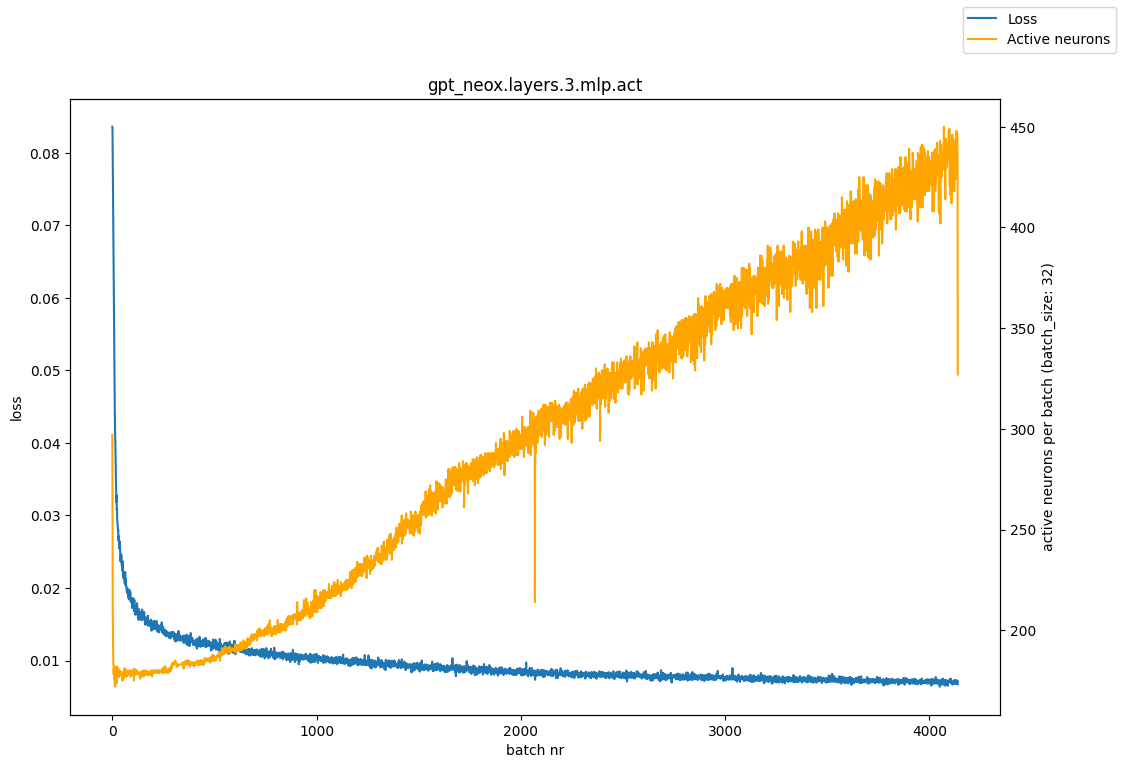

In [9]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint
    k = sae_trainer.model.k

    model_out_path = f'{out_folder}/topk{k}/{hookpoint}.pt'
    meta_data_out_path = f'{out_folder}/topk{k}/{hookpoint}.json'
    log_path = f'{log_folder}/topk{k}/{hookpoint}.csv'
    log_fig_path = f'{log_folder}/topk{k}/{hookpoint}.png'


    if not os.path.isdir(f'{out_folder}'):
        os.mkdir(f'{out_folder}')
    if not os.path.isdir(f'{log_folder}'):
        os.mkdir(f'{log_folder}')

    if not os.path.isdir(f'{out_folder}/topk{k}'):
        os.mkdir(f'{out_folder}/topk{k}')
    if not os.path.isdir(f'{log_folder}/topk{k}'):
        os.mkdir(f'{log_folder}/topk{k}')

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses)
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)

In [9]:
# too big to commit :((((